# In this notebook, I analyze air travel information in 2007 and 2008.
## The two files are available in google cloud storage.



My goal is to determine:

    Which locations (Origin and Dest pairs) had the lowest delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year
    Which locations had fewest amount of delays.
    Did the holidays have an effect on the size of the delays?
    What day of the week has the largest delay lengths?
    If you wanted to ensure you took off at a certain time, what time of day would you pick?

For both 2007 and 2008


In [1]:

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark with Hadoop=
!wget -nc -q https://storage.googleapis.com/msca-bdp-data-open/spark_hadoop/spark-3.5.3-bin-hadoop3.tgz

# Unzip the folder
!tar xf spark-3.5.3-bin-hadoop3.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [2]:

# Setting the environment variables, to enable running PySpark in Colab environment.

import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [3]:
# Locate Spark in the system

import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark.version

'3.5.3'

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import shutil
from itertools import islice
import requests
import pandas as pd

pd.set_option("max_colwidth", 100)

## Helper functions

In [7]:
def list_files(dir_name):
    try:
        list_of_files = [file_name for file_name in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, file_name))]
        files_with_size = [ (file_name, os.stat(os.path.join(dir_name, file_name)).st_size)
                    for file_name in list_of_files if not file_name.startswith('.')]
        for file_name, size in files_with_size:
            print(file_name, ' -->', size)
    except OSError as e:
        print("Error: %s : %s" % (dir_name, e.strerror))

In [8]:
def delete_folder(dir_name):
    try:
        shutil.rmtree(dir_name)
    except OSError as e:
        print("Error: %s : %s" % (dir_name, e.strerror))

In [9]:
def get_gcs_data (bucket_name, folder_name, file_name, path_gdrive):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_gdrive + '/' + file_name , 'wb').write(r.content)

## Download data

In [10]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'airlines'
file_name = ['2007.csv', '2008.csv']
path_gdrive = '/content/drive/My Drive/BDP/airlines'

os.makedirs(path_gdrive, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_gdrive = path_gdrive)
    print('Downloaded: ' + file)

Downloaded: 2007.csv
Downloaded: 2008.csv


In [11]:
list_files(path_gdrive)

2007.csv  --> 702878193
2008.csv  --> 689413344


In [12]:
path2007 = path_gdrive + '/2007.csv'
path2008 = path_gdrive + '/2008.csv'

In [13]:
airline_raw = sc.textFile("file://" + path2007)
airline_raw.take(10)

['Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay',
 '2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,,0,0,0,0,0,0',
 '2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,,0,0,0,0,0,0',
 '2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,,0,3,0,0,0,31',
 '2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,,0,23,0,0,0,3',
 '2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,,0,0,0,0,0,0',
 '2007,1,1,1,1430,1420,1553,1550,WN,2386,N611SW,83,90,74,3,10,SMF,PDX,479,2,7,0,,0,0,0,0,0,0',
 '2007,1,1,1,1936,1840,2217,2130,WN,409,N482,101,110,89,47,56,SMF,PHX,647,5,7,0,,0,46,0,0,0,1',
 '2007,1,1,1,944,935,1223,1225,WN,1131,N

In [14]:
airline2007_df = spark.read.csv(path2007, header='true', inferSchema='true', sep=',', quote='"')
airline2008_df = spark.read.csv(path2008, header='true', inferSchema='true', sep=',', quote='"')
airline2007_df.cache()
airline2008_df.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [15]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [16]:
airline2007_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- C

In [17]:
airline2007_df.limit(5)

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,NULL,0,0,0,0,0,0
2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,NULL,0,0,0,0,0,0
2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,NULL,0,3,0,0,0,31
2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,NULL,0,23,0,0,0,3
2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,NULL,0,0,0,0,0,0


# Determine which locations (Origin and Dest pairs) had the lowest delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year

### Negative means they arrived/took off early

In [20]:
airline2007_df = airline2007_df.filter(airline2007_df.ArrDelay != "NA")
airline2008_df = airline2008_df.filter(airline2008_df.ArrDelay != "NA")

# Group by 'Origin' and 'Dest', and aggregate using min on 'ArrDelay' and 'DepDelay'
result2007_df = airline2007_df.groupby('Origin', 'Dest') \
    .agg(min('ArrDelay').alias('minArrDelay'), min('DepDelay').alias('minDepDelay')) \
    .orderBy(col('minArrDelay').asc(), col('minDepDelay').asc())
result2008_df = airline2008_df.groupby('Origin', 'Dest') \
    .agg(min('ArrDelay').alias('minArrDelay'), min('DepDelay').alias('minDepDelay')) \
    .orderBy(col('minArrDelay').asc(), col('minDepDelay').asc())

# Select and show the relevant columns
result2007_df.select('Origin', 'Dest', 'minArrDelay', 'minDepDelay').show(5)
result2008_df.select('Origin', 'Dest', 'minArrDelay', 'minDepDelay').show(5)

+------+----+-----------+-----------+
|Origin|Dest|minArrDelay|minDepDelay|
+------+----+-----------+-----------+
|   ABQ| ATL|         -1|         -1|
|   ABQ| AMA|         -1|         -1|
|   ABE| ATL|         -1|         -1|
|   ABE| CLE|         -1|         -1|
|   ABE| CLT|         -1|         -1|
+------+----+-----------+-----------+
only showing top 5 rows

+------+----+-----------+-----------+
|Origin|Dest|minArrDelay|minDepDelay|
+------+----+-----------+-----------+
|   ABQ| AUS|         -1|         -1|
|   ABQ| ATL|         -1|         -1|
|   ABE| ORD|         -1|         -1|
|   ABE| CLE|         -1|         -1|
|   ABI| DFW|         -1|         -1|
+------+----+-----------+-----------+
only showing top 5 rows



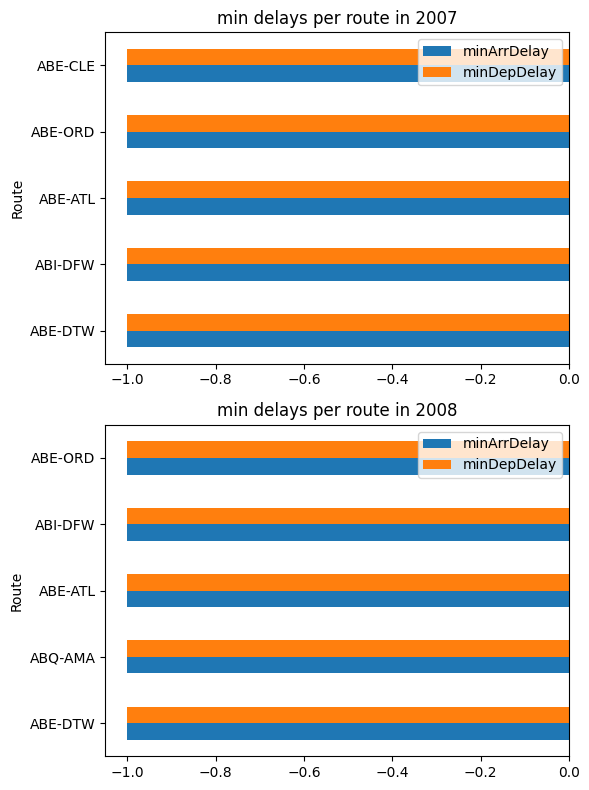

In [24]:
# Plot
import matplotlib.pyplot as plt

pair_delay_2007 = result2007_df.select('Origin', 'Dest', 'minArrDelay', 'minDepDelay').limit(5).toPandas()
pair_delay_2008 = result2008_df.select('Origin', 'Dest', 'minArrDelay', 'minDepDelay').limit(5).toPandas()
pair_delay_2007['minArrDelay'] = pair_delay_2007['minArrDelay'].astype(int)
pair_delay_2007['minDepDelay'] = pair_delay_2007['minDepDelay'].astype(int)
pair_delay_2008['minArrDelay'] = pair_delay_2008['minArrDelay'].astype(int)
pair_delay_2008['minDepDelay'] = pair_delay_2008['minDepDelay'].astype(int)

# Combine Origin and Dest into a single column 'Route' for both 2007 and 2008 data
pair_delay_2007['Route'] = pair_delay_2007['Origin'] + '-' + pair_delay_2007['Dest']
pair_delay_2008['Route'] = pair_delay_2008['Origin'] + '-' + pair_delay_2008['Dest']

fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Plot bar charts with 'Route' as the x-axis for both 2007 and 2008 data
pair_delay_2007.plot(kind='barh', x='Route', y=['minArrDelay', 'minDepDelay'], ax=axes[0])
pair_delay_2008.plot(kind='barh', x='Route', y=['minArrDelay', 'minDepDelay'], ax=axes[1])

# Set titles for each subplot to distinguish them
axes[0].set_title("min delays per route in 2007")
axes[1].set_title("min delays per route in 2008")

plt.tight_layout()  # Adjust layout to fit subplots neatly
plt.show()


In 2007, these locations had the lowest delays:

ABQ -> ATL

ABQ -> AMA

ABE -> ATL

ABE -> CLE

ABE -> CLT

In 2008, these locations had the lowest delays:

ABQ -> AUS

ABQ -> ATL

ABE -> ORD

ABE -> CLE

ABI -> DFW

# Determine which locations had fewest total amount of delays

In [25]:
# Select origin, dest from 2007 group by origin, dest, orderby count(arrDelay) count(DepDelay)
tot_delay_2007_df = airline2007_df.filter((airline2007_df.DepDelay >= 0) & (airline2007_df.ArrDelay >= 0)).groupby('Origin', 'Dest') \
              .agg(count('ArrDelay').alias('CountArrDelay'), count('DepDelay').alias('CountDepDelay')) \
              .orderBy(col('CountArrDelay').asc(), col('CountDepDelay').asc())
tot_delay_2008_df = airline2008_df.filter((airline2008_df.DepDelay >= 0) & (airline2008_df.ArrDelay >= 0)).groupby('Origin', 'Dest') \
              .agg(count('ArrDelay').alias('CountArrDelay'), count('DepDelay').alias('CountDepDelay')) \
              .orderBy(col('CountArrDelay').asc(), col('CountDepDelay').asc())

tot_delay_2007_df.select('Origin', 'Dest', 'CountArrDelay', 'CountDepDelay').show(5)
tot_delay_2008_df.select('Origin', 'Dest', 'CountArrDelay', 'CountDepDelay').show(5)

+------+----+-------------+-------------+
|Origin|Dest|CountArrDelay|CountDepDelay|
+------+----+-------------+-------------+
|   GSO| BTR|            1|            1|
|   CLE| ERI|            1|            1|
|   BWI| ABE|            1|            1|
|   ACY| JFK|            1|            1|
|   MSY| SFO|            1|            1|
+------+----+-------------+-------------+
only showing top 5 rows

+------+----+-------------+-------------+
|Origin|Dest|CountArrDelay|CountDepDelay|
+------+----+-------------+-------------+
|   OMA| DSM|            1|            1|
|   ACY| JFK|            1|            1|
|   JFK| HPN|            1|            1|
|   XNA| SGF|            1|            1|
|   CDC| SGU|            1|            1|
+------+----+-------------+-------------+
only showing top 5 rows



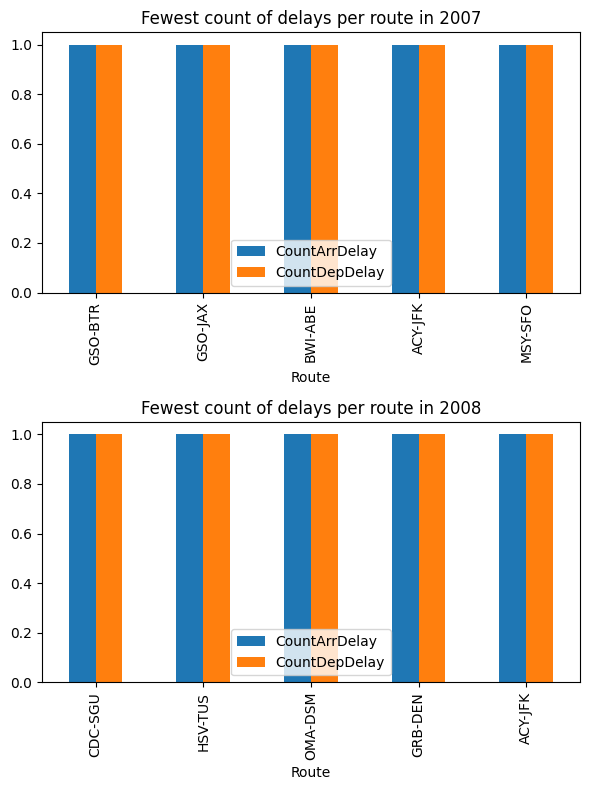

In [26]:
#Plot
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

#convert to pandas
tot_delay_2007 = tot_delay_2007_df.select('Origin', 'Dest', 'CountArrDelay', 'CountDepDelay').limit(5).toPandas()
tot_delay_2008 = tot_delay_2008_df.select('Origin', 'Dest', 'CountArrDelay', 'CountDepDelay').limit(5).toPandas()

#Change to int type
tot_delay_2007['CountArrDelay'] = tot_delay_2007['CountArrDelay'].astype(int)
tot_delay_2007['CountDepDelay'] = tot_delay_2007['CountDepDelay'].astype(int)
tot_delay_2008['CountArrDelay'] = tot_delay_2008['CountArrDelay'].astype(int)
tot_delay_2008['CountDepDelay'] = tot_delay_2008['CountDepDelay'].astype(int)

# Combine Origin and Dest into a single column 'Route' for both 2007 and 2008 data
tot_delay_2007['Route'] = tot_delay_2007['Origin'] + '-' + tot_delay_2007['Dest']
tot_delay_2008['Route'] = tot_delay_2008['Origin'] + '-' + tot_delay_2008['Dest']

# Plot bar charts with 'Route' as the x-axis for both 2007 and 2008 data
tot_delay_2007.plot(kind='bar', x='Route', y=['CountArrDelay', 'CountDepDelay'], ax=axes[0])
tot_delay_2008.plot(kind='bar', x='Route', y=['CountArrDelay', 'CountDepDelay'], ax=axes[1])

# Set titles for each subplot to distinguish them
axes[0].set_title("Fewest count of delays per route in 2007")
axes[1].set_title("Fewest count of delays per route in 2008")

plt.tight_layout()  # Adjust layout to fit subplots neatly
plt.show()

# Determine if the holidays have an effect on the length of the delays.

In [27]:
#To determine the effect of holidays on the length of delays, group by the month and get the average delays
airline2007month_df_grouped = airline2007_df.groupby('Month').agg(avg('ArrDelay'), avg('DepDelay')).\
    withColumnRenamed('avg(ArrDelay)', 'Avg_Month_Arr_Delay').\
    withColumnRenamed('avg(DepDelay)', 'Avg_Month_Dep_Delay').\
    orderBy('Month', ascending=True)

airline2008month_df_grouped = airline2008_df.groupby('Month').agg(avg('ArrDelay'), avg('DepDelay')).\
    withColumnRenamed('avg(ArrDelay)', 'Avg_Month_Arr_Delay').\
    withColumnRenamed('avg(DepDelay)', 'Avg_Month_Dep_Delay').\
    orderBy('Month', ascending=True)

In [28]:
pd_2007 = airline2007month_df_grouped.limit(1000).toPandas()
pd_2008 = airline2008month_df_grouped.limit(1000).toPandas()
pd_2007.head(13)

,Month,Avg_Month_Arr_Delay,Avg_Month_Dep_Delay
0,1,9.162152,10.252986
1,2,13.519795,13.982618
2,3,10.084908,11.791911
3,4,8.516230,10.058320
4,5,7.037889,8.305957
5,6,16.179528,16.135026
6,7,14.107680,14.771436
7,8,12.571533,13.471745
8,9,3.749498,6.141357
9,10,6.508259,7.942427


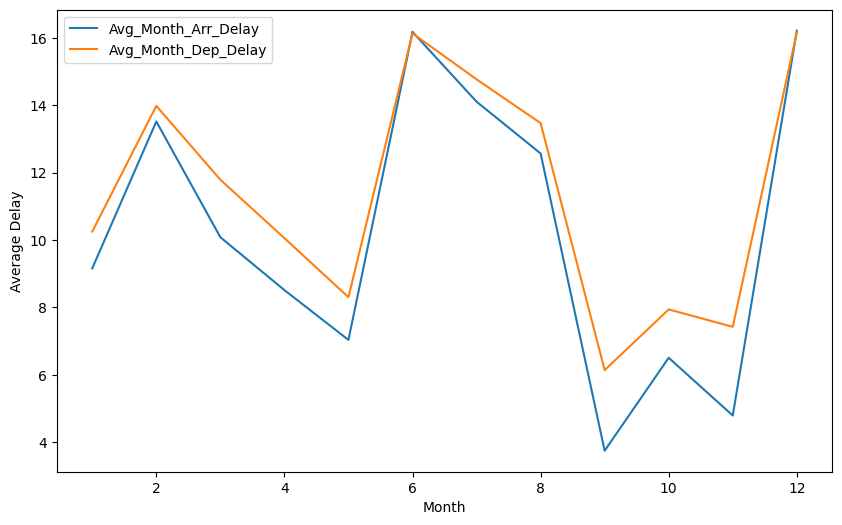

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
# Month|Avg_Month_Arr_Delay|Avg_Month_Dep_Delay
for delay in ['Avg_Month_Arr_Delay','Avg_Month_Dep_Delay']:
    ax.plot(pd_2007.Month,pd_2007[delay],label=delay)

ax.set_xlabel("Month")
ax.set_ylabel("Average Delay")
ax.legend(loc='best')

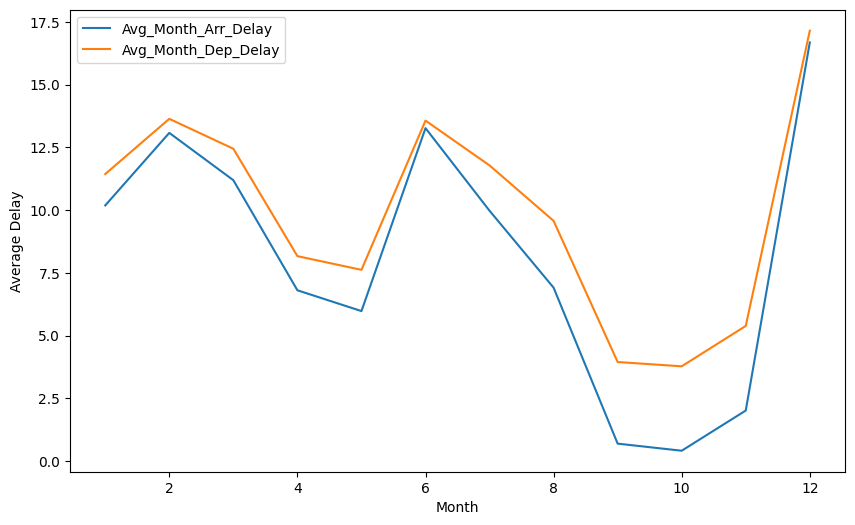

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
# Month|Avg_Month_Arr_Delay|Avg_Month_Dep_Delay
for delay in ['Avg_Month_Arr_Delay','Avg_Month_Dep_Delay']:
    ax.plot(pd_2008.Month,pd_2008[delay],label=delay)

ax.set_xlabel("Month")
ax.set_ylabel("Average Delay")
ax.legend(loc='best')

# In both 2007 and 2008, we see that the holidays has an effect on the length of delays. In both years, delays peaked in Februaru, June, and December.

### It also appears that the departure delay and arrival delay lengths follow similar seasonal effects.

# Determine which day of the week has the longest delays

In [31]:
#To determine which day of the week has the longest delays, group by the day of the week and get the average delays
weekdelay2007 = airline2007_df.groupby('DayOfWeek').agg(avg('ArrDelay').alias('Average Arrival Delay'), avg('DepDelay').alias('Average Departure Delay')).orderBy('DayOfWeek', ascending=True)
weekdelay2008 = airline2008_df.groupby('DayOfWeek').agg(avg('ArrDelay').alias('Average Arrival Delay'), avg('DepDelay').alias('Average Departure Delay')).orderBy('DayOfWeek', ascending=True)
weekdelay2007.show(10)
weekdelay2008.show(10)

+---------+---------------------+-----------------------+
|DayOfWeek|Average Arrival Delay|Average Departure Delay|
+---------+---------------------+-----------------------+
|        1|   10.513502556550229|     11.865883613993091|
|        2|    8.263684434009868|      9.357213853615066|
|        3|    9.962943847767281|     10.641331658884127|
|        4|   12.685980155261941|     12.840757895130421|
|        5|   13.067675000697863|     13.536222794986555|
|        6|    5.846600031017031|      8.965287136887769|
|        7|    10.32957740663109|     11.949764439393284|
+---------+---------------------+-----------------------+

+---------+---------------------+-----------------------+
|DayOfWeek|Average Arrival Delay|Average Departure Delay|
+---------+---------------------+-----------------------+
|        1|    8.210850494863875|     10.222610789315283|
|        2|    7.481207604036612|      8.916445657619544|
|        3|    6.522017315719349|      8.233873322877693|
|        4|  

In [33]:
pd_week_2007 = weekdelay2007.limit(1000).toPandas()
pd_week_2008 = weekdelay2008.limit(1000).toPandas()

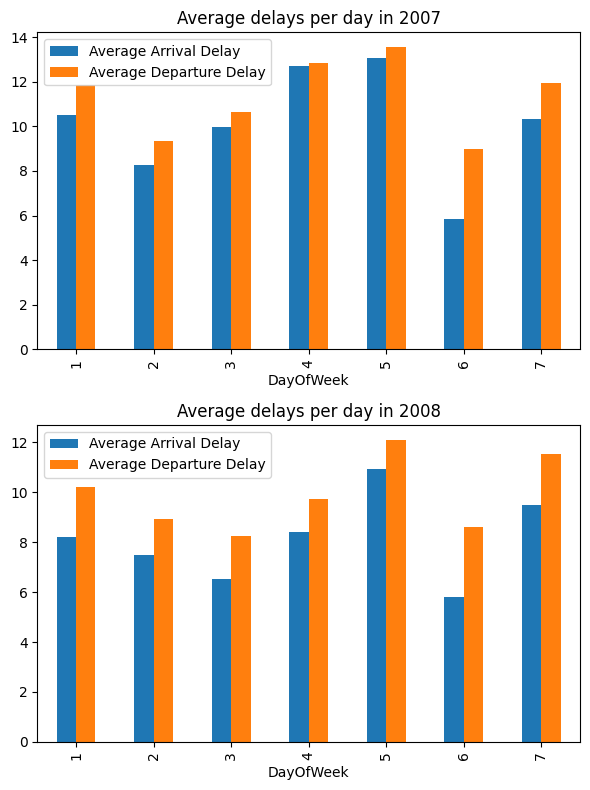

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Plot histograms with additional bins for both pd_2007 and pd_2008
pd_week_2007.plot(kind='bar', x='DayOfWeek', y=['Average Arrival Delay', 'Average Departure Delay'], ax=axes[0])
pd_week_2008.plot(kind='bar', x='DayOfWeek', y=['Average Arrival Delay', 'Average Departure Delay'], ax=axes[1])

# Set titles for each subplot to distinguish them
axes[0].set_title("Average delays per day in 2007")
axes[1].set_title("Average delays per day in 2008")

plt.tight_layout()  # Adjust layout to fit subplots neatly
plt.show()

## From the above graph, in 2007, the worst delays occured on Thursday and Friday

## We also see that in 2008, the worst delays occured on Friday and Sunday.

# If you wanted to ensure you took off at a certain time, what time of day would you pick?

In [35]:
#add a column "hour." Then group by the hour and average the depdelay and arr delay


airline2007_df = airline2007_df.withColumn('ArrTimeHour',when(length(col('ArrTime')) == 4, substring('ArrTime', 1, 2)).otherwise(substring('ArrTime', 1, 1))).\
                                withColumn('DepTimeHour',when(length(col('DepTime')) == 4, substring('DepTime', 1, 2)).otherwise(substring('DepTime', 1, 1)))

airline2008_df = airline2008_df.withColumn('ArrTimeHour',when(length(col('ArrTime')) == 4, substring('ArrTime', 1, 2)).otherwise(substring('ArrTime', 1, 1))).\
                                withColumn('DepTimeHour',when(length(col('DepTime')) == 4, substring('DepTime', 1, 2)).otherwise(substring('DepTime', 1, 1)))
airline2007_df.show(10)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+-----------+-----------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|ArrTimeHour|DepTimeHour|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+-----------+-----------+
|2007|    1|         1

In [36]:
airline2007_Arrdelay = airline2007_df.groupby('ArrTimeHour').agg(avg('ArrDelay')).withColumnRenamed('avg(ArrDelay)', 'Arr_Delay')
airline2007_Depdelay = airline2007_df.groupby('DepTimeHour').agg(avg('DepDelay')).withColumnRenamed('avg(DepDelay)', 'Dep_Delay')

airline2008_Arrdelay = airline2007_df.groupby('ArrTimeHour').agg(avg('ArrDelay')).withColumnRenamed('avg(ArrDelay)', 'Arr_Delay')
airline2008_Depdelay = airline2007_df.groupby('DepTimeHour').agg(avg('DepDelay')).withColumnRenamed('avg(DepDelay)', 'Dep_Delay')

In [37]:
pd_2007_arr_delay = airline2007_Arrdelay['ArrTimeHour', 'Arr_Delay'].limit(10000).toPandas()
pd_2007_dep_delay = airline2007_Depdelay['DepTimeHour', 'Dep_Delay'].limit(10000).toPandas()
pd_2008_arr_delay = airline2008_Arrdelay['ArrTimeHour', 'Arr_Delay'].limit(10000).toPandas()
pd_2008_dep_delay = airline2008_Depdelay['DepTimeHour', 'Dep_Delay'].limit(10000).toPandas()

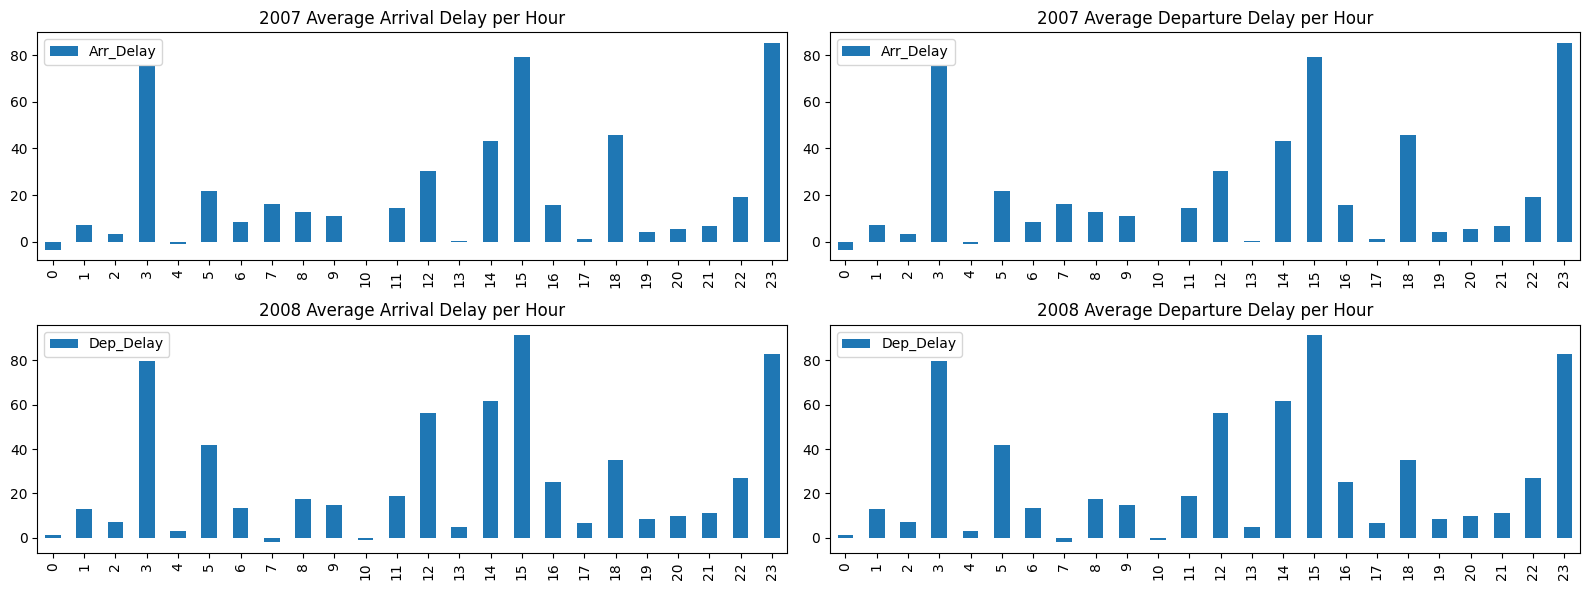

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6))  # 16 is the width, 6 is the height

# Plot histograms with additional bins for both pd_2007 and pd_2008
pd_2007_arr_delay.plot(kind = 'bar', ax = axes[0][0])
pd_2007_dep_delay.plot(kind = 'bar', ax = axes[1][0])
pd_2008_arr_delay.plot(kind = 'bar', ax = axes[0][1])
pd_2008_dep_delay.plot(kind = 'bar', ax = axes[1][1])

# # Set titles for each subplot to distinguish them
axes[0][0].set_title("2007 Average Arrival Delay per Hour")
axes[0][1].set_title("2007 Average Departure Delay per Hour")
axes[1][0].set_title("2008 Average Arrival Delay per Hour")
axes[1][1].set_title("2008 Average Departure Delay per Hour")

plt.tight_layout()  # Adjust layout to fit subplots neatly
plt.show()

# If I were to plan a flight in 2007, I would want to take off at midnight or 10:00 AM as those times have the lowest departure delays

# And in 2008, I would want to leave at either 7:00 AM or 10:00 as those times have the lowest departure delays